🚀 Cinnamon Price Forecasting - Inference Mode
📂 Available Models:
1. cinnamon_model_20250924_114850
2. cinnamon_model_20250923_183211
3. cinnamon_model_20250923_151802
📂 Loading model from: cinnamon_models\cinnamon_model_20250924_114850
✅ Keras model loaded
✅ Scalers loaded
✅ Label encoders loaded
🎉 Model successfully loaded!
📊 Performance: MAE=66.56, RMSE=100.21, R²=0.9864
📊 Loading data from C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv...
Initial data shape: (2898, 16)
Missing Regional_Price values: 0 -> 0
Creating lag and rolling features...
Final data shape after feature engineering: (2898, 46)

🎯 Interactive Forecast Generator

Options:
1. Single forecast
2. Multiple forecasts comparison
3. Exit

Available Grades: alba, c4, c5, c5sp, h1, h2, h_faq
Available Regions: colombo, galle, hambantota, kalutara, matara, ratnapura

Forecast 1:

Forecast 2:

🔮 Generating comparison for 2 forecasts...
🔮 Generating 6-month forecast starting from 2025-

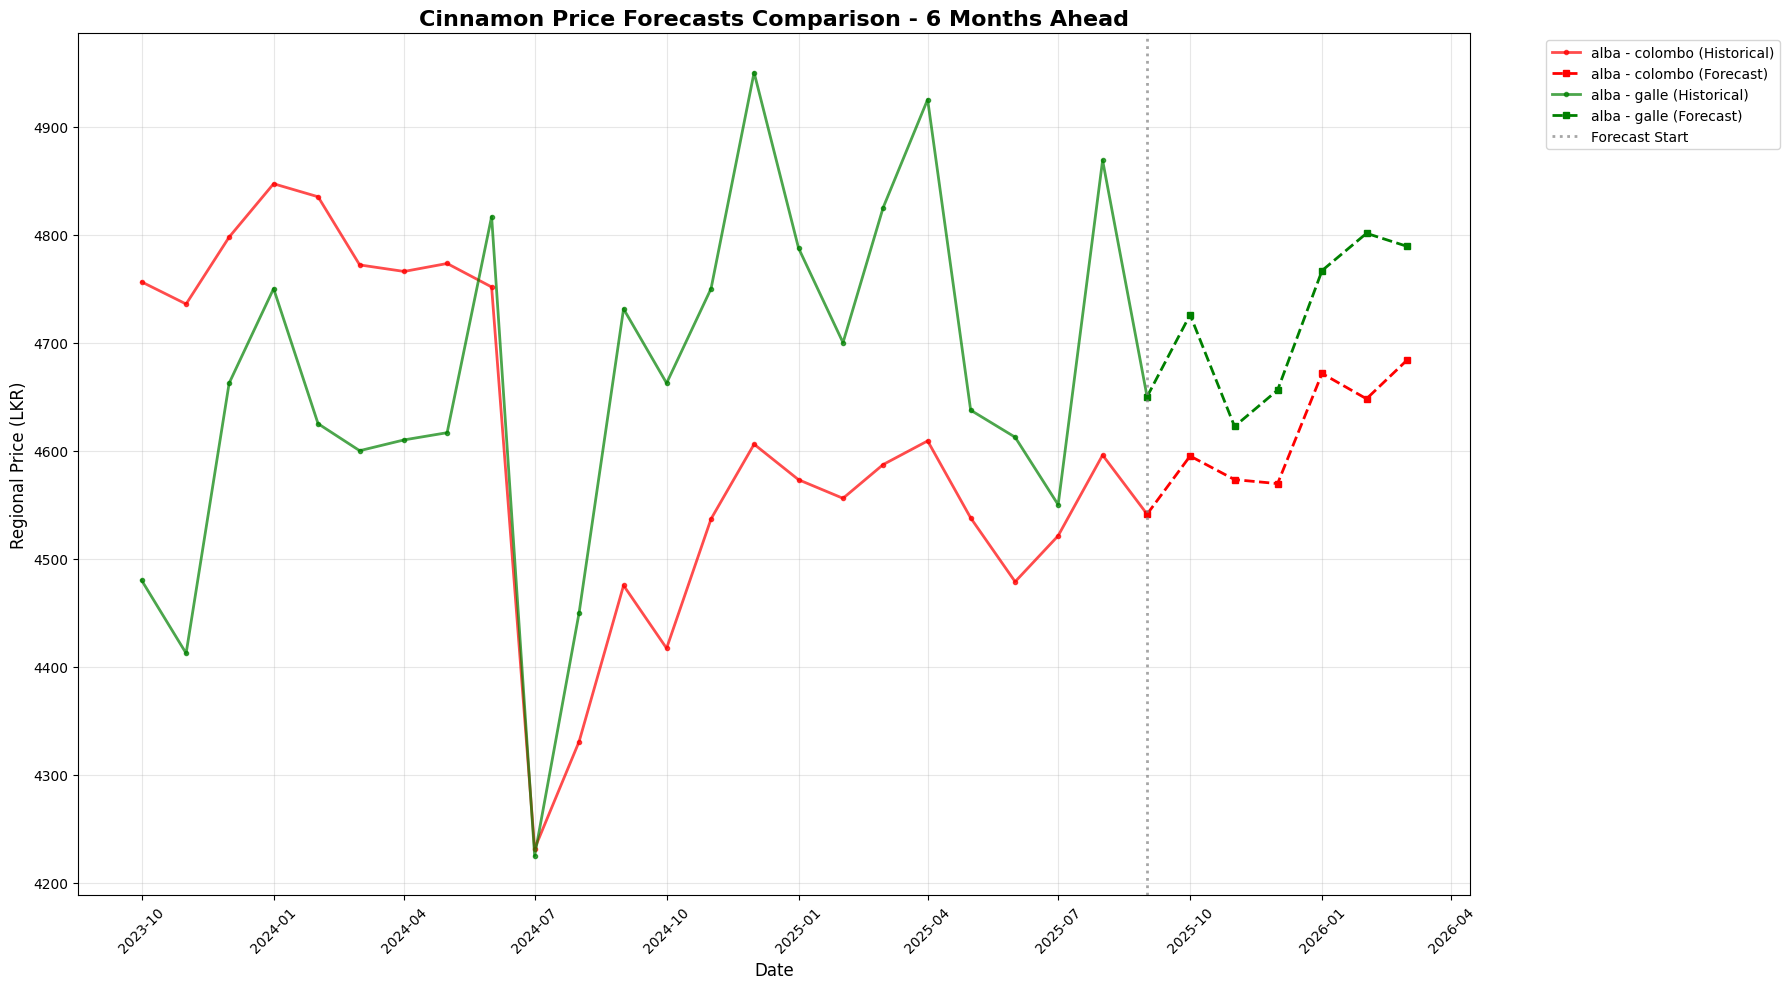


📊 FORECAST COMPARISON SUMMARY (6 months)
alba - colombo                 | Avg: LKR 4,623.48 | Trend:   +1.9%
alba - galle                   | Avg: LKR 4,726.91 | Trend:   +1.3%

Options:
1. Single forecast
2. Multiple forecasts comparison
3. Exit
👋 Goodbye!


In [2]:
# Cinnamon Price Forecasting - Inference & Plotting
# This notebook loads saved models and generates forecasts without retraining

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import os
from datetime import datetime
import json

warnings.filterwarnings("ignore")

# Configuration
SEQUENCE_LENGTH = 12
MODEL_DIR = 'cinnamon_models'
DATA_PATH = 'C:/VERGER/Spice_Price_Prediction/Cinnamon/Datasets/Cinnamon_Dataset_New_0001_Filled.csv'

# Global variables for preprocessors
scaler_features = None
scaler_target = None
label_encoders = {}

print("🚀 Cinnamon Price Forecasting - Inference Mode")
print("=" * 60)

def list_available_models(model_dir=MODEL_DIR):
    """List all available saved models"""
    if not os.path.exists(model_dir):
        print(f"❌ Model directory not found: {model_dir}")
        return []
    
    model_folders = []
    for item in os.listdir(model_dir):
        item_path = os.path.join(model_dir, item)
        if os.path.isdir(item_path):
            # Check if it contains required model files
            required_files = ['lstm_model.keras', 'scalers.pkl', 'label_encoders.pkl', 'model_config.json']
            if all(os.path.exists(os.path.join(item_path, f)) for f in required_files):
                model_folders.append(item)
    
    return sorted(model_folders, reverse=True)  # Most recent first

def load_saved_model(model_path):
    """Load a previously saved model and preprocessors"""
    global scaler_features, scaler_target, label_encoders
    
    print(f"📂 Loading model from: {model_path}")
    
    try:
        # Load the Keras model
        keras_model_path = os.path.join(model_path, "lstm_model.keras")
        model = load_model(keras_model_path)
        print(f"✅ Keras model loaded")
        
        # Load scalers
        scalers_path = os.path.join(model_path, "scalers.pkl")
        with open(scalers_path, 'rb') as f:
            scalers = pickle.load(f)
        scaler_features = scalers['scaler_features']
        scaler_target = scalers['scaler_target']
        print(f"✅ Scalers loaded")
        
        # Load label encoders
        encoders_path = os.path.join(model_path, "label_encoders.pkl")
        with open(encoders_path, 'rb') as f:
            label_encoders = pickle.load(f)
        print(f"✅ Label encoders loaded")
        
        # Load configuration
        config_path = os.path.join(model_path, "model_config.json")
        with open(config_path, 'r') as f:
            config = json.load(f)
        
        print(f"🎉 Model successfully loaded!")
        print(f"📊 Performance: MAE={config['training_info']['mae']:.2f}, "
              f"RMSE={config['training_info']['rmse']:.2f}, "
              f"R²={config['training_info']['r2']:.4f}")
        
        if config['training_info'].get('used_hyperparameter_tuning', False):
            print("🔍 This model was trained using hyperparameter tuning")
            if 'best_hyperparameters' in config:
                print("📋 Best hyperparameters:")
                for param, value in config['best_hyperparameters'].items():
                    print(f"   • {param}: {value}")
        
        return model, config
        
    except Exception as e:
        print(f"❌ Error loading model: {str(e)}")
        return None, None

def load_and_prepare_data(data_path):
    """Load and prepare the cinnamon price dataset (same as training)"""
    print(f"📊 Loading data from {data_path}...")
    df = pd.read_csv(data_path)
    print(f"Initial data shape: {df.shape}")

    # Convert Month to datetime
    df['Month'] = pd.to_datetime(df['Month'])

    # Handle missing values in Regional_Price
    missing_before = df['Regional_Price'].isna().sum()
    df.loc[df['Is_Active_Region'] == 0, 'Regional_Price'] = df.loc[df['Is_Active_Region'] == 0, 'National_Price']
    missing_after = df['Regional_Price'].isna().sum()
    print(f"Missing Regional_Price values: {missing_before} -> {missing_after}")

    # Encode categorical variables using loaded encoders
    for col in ['Grade', 'Region']:
        if col in label_encoders:
            df[f'{col}_encoded'] = label_encoders[col].transform(df[col])
        else:
            print(f"⚠️ Warning: No encoder found for {col}")

    # Create additional time-based features
    df['Year'] = df['Month'].dt.year
    df['Month_num'] = df['Month'].dt.month
    df['Quarter'] = df['Month'].dt.quarter

    print("Creating lag and rolling features...")

    # Create lag features for key variables
    df = df.sort_values(['Grade', 'Region', 'Month'])
    lag_columns = ['Regional_Price', 'National_Price', 'Temperature', 'Rainfall']
    for col in lag_columns:
        if col in df.columns:
            for lag in [1, 3, 6, 12]:
                df[f'{col}_lag_{lag}'] = df.groupby(['Grade', 'Region'])[col].shift(lag)

    # Create rolling averages
    for col in ['Regional_Price', 'Temperature', 'Rainfall']:
        if col in df.columns:
            for window in [3, 6, 12]:
                df[f'{col}_rolling_{window}'] = df.groupby(['Grade', 'Region'])[col].transform(
                    lambda x: x.rolling(window).mean()
                )

    print(f"Final data shape after feature engineering: {df.shape}")
    return df

# Define feature columns (same as training)
TRAIN_FEATURE_COLS = [
    'Grade_encoded', 'Region_encoded', 'Is_Active_Region',
    'National_Price', 'Seasonal_Impact', 'Local_Production_Volume',
    'Local_Export_Volume', 'Global_Production_Volume', 'Global_Consumption_Volume',
    'Temperature', 'Rainfall', 'Exchange_Rate', 'Inflation_Rate', 'Fuel_Price',
    'Year', 'Month_num', 'Quarter',
    'Regional_Price_lag_1', 'Regional_Price_lag_3', 'Regional_Price_lag_6', 'Regional_Price_lag_12',
    'National_Price_lag_1', 'National_Price_lag_3', 'National_Price_lag_6', 'National_Price_lag_12',
    'Temperature_lag_1', 'Temperature_lag_3', 'Temperature_lag_6', 'Temperature_lag_12',
    'Rainfall_lag_1', 'Rainfall_lag_3', 'Rainfall_lag_6', 'Rainfall_lag_12',
    'Regional_Price_rolling_3', 'Regional_Price_rolling_6', 'Regional_Price_rolling_12',
    'Temperature_rolling_3', 'Temperature_rolling_6', 'Temperature_rolling_12',
    'Rainfall_rolling_3', 'Rainfall_rolling_6', 'Rainfall_rolling_12'
]

def forecast_prices(model, df, grade, region, months_ahead=12):
    """Generate price forecasts for specified grade and region"""
    subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
    
    if len(subset) == 0:
        print(f"❌ No data found for {grade} in {region}")
        return None, None
    
    last_row = subset.iloc[-1]
    last_date = last_row['Month']

    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                 periods=months_ahead, freq='MS')
    
    print(f"🔮 Generating {months_ahead}-month forecast starting from {last_date.strftime('%Y-%m')}")
    
    # Generate future rows with realistic seasonal patterns
    future_rows = []
    for future_date in future_dates:
        row = last_row.copy()
        row['Month'] = future_date
        row['Year'] = future_date.year
        row['Month_num'] = future_date.month
        row['Quarter'] = future_date.quarter
        
        # Add seasonal patterns and random variations
        row['Temperature'] = last_row['Temperature'] + 2 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,0.5)
        row['Rainfall'] = max(0, last_row['Rainfall'] + 20 * np.sin(2*np.pi*(future_date.month-1)/12) + np.random.normal(0,10))
        row['Exchange_Rate'] = last_row['Exchange_Rate'] * (1 + np.random.normal(0.001,0.005))
        row['Inflation_Rate'] = last_row['Inflation_Rate'] + np.random.normal(0,0.1)
        row['Fuel_Price'] = last_row['Fuel_Price'] * (1 + np.random.normal(0.002,0.02))
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)
    extended_df = pd.concat([subset, future_df], ignore_index=True).sort_values('Month')

    # Recreate lag and rolling features for extended data
    for col in ['Regional_Price','National_Price','Temperature','Rainfall']:
        for lag in [1,3,6,12]:
            extended_df[f'{col}_lag_{lag}'] = extended_df.groupby(['Grade','Region'])[col].shift(lag)
        for window in [3,6,12]:
            extended_df[f'{col}_rolling_{window}'] = extended_df.groupby(['Grade','Region'])[col].transform(
                lambda x: x.rolling(window).mean()
            )

    # Select exactly the features used during training
    feature_cols = [c for c in TRAIN_FEATURE_COLS if c in extended_df.columns]
    missing_cols = [c for c in TRAIN_FEATURE_COLS if c not in extended_df.columns]
    if missing_cols:
        print(f"⚠️ Warning: Missing feature columns: {missing_cols}")

    forecasts = []
    historical_data = extended_df[extended_df['Month'] <= last_date]

    print("Generating sequential forecasts...")
    for i in range(months_ahead):
        # Get the sequence needed for prediction
        current_data = extended_df.iloc[len(historical_data)-SEQUENCE_LENGTH+i : len(historical_data)+i]
        
        if len(current_data) < SEQUENCE_LENGTH:
            # Pad with last known data if needed
            padding_needed = SEQUENCE_LENGTH - len(current_data)
            last_known = historical_data.iloc[-1:].copy()
            padding_data = pd.concat([last_known]*padding_needed, ignore_index=True)
            current_data = pd.concat([padding_data, current_data], ignore_index=True).iloc[-SEQUENCE_LENGTH:]

        # Prepare sequence for model
        sequence = current_data[feature_cols].fillna(method='ffill').fillna(method='bfill').values
        sequence_flat = sequence.reshape(-1, sequence.shape[-1])
        sequence_scaled_flat = scaler_features.transform(sequence_flat)
        sequence_scaled = sequence_scaled_flat.reshape(sequence.shape)

        # Make prediction
        next_pred = model.predict(sequence_scaled.reshape(1, SEQUENCE_LENGTH, -1), verbose=0)
        next_pred_unscaled = scaler_target.inverse_transform(next_pred)[0][0]
        forecasts.append(next_pred_unscaled)

        # Update the extended dataframe with the new prediction
        future_idx = len(historical_data)+i
        extended_df.iloc[future_idx, extended_df.columns.get_loc('Regional_Price')] = next_pred_unscaled
        extended_df.iloc[future_idx, extended_df.columns.get_loc('National_Price')] = next_pred_unscaled

    print(f"✅ Forecast generation completed!")
    return forecasts, future_dates

def plot_forecast_results(df, model, grade, region, months_ahead=12):
    """Plot historical data with forecast results"""
    try:
        # Get historical data for the specific grade and region
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        
        if len(subset) == 0:
            print(f"❌ No data found for {grade} in {region}")
            return None, None
        
        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        
        if forecasts is None:
            return None, None
        
        # Create the plot
        plt.figure(figsize=(16, 8))
        
        # Plot historical data
        plt.plot(subset['Month'], subset['Regional_Price'], 
                label='Historical Prices', linewidth=2, color='blue', marker='o', markersize=4)
        
        # CREATE BRIDGE: Connect last historical point to first forecast
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        first_forecast_date = future_dates[0]
        first_forecast_price = forecasts[0]
        
        # Plot the connecting line (bridge)
        plt.plot([last_historical_date, first_forecast_date], 
                [last_historical_price, first_forecast_price], 
                color='orange', linewidth=2, linestyle='-', alpha=0.8, 
                label='Historical-Forecast Bridge')
        
        # Plot forecasts (connected line)
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                label='Forecasted Prices', linewidth=2, color='red', 
                marker='s', markersize=5, linestyle='--', alpha=0.9)
        
        # Add a vertical line to separate historical and forecasted data
        plt.axvline(x=last_historical_date, color='blue', linestyle=':', alpha=0.5, linewidth=1, 
                   label='Forecast Start')
        
        # Add confidence bands (simplified approach using standard deviation)
        if len(forecasts) > 1:
            forecast_std = np.std(subset['Regional_Price'].tail(12))  # Use last 12 months std
            upper_bound = np.array(extended_forecasts[1:]) + 1.96 * forecast_std  # Exclude bridge point
            lower_bound = np.array(extended_forecasts[1:]) - 1.96 * forecast_std
            
            plt.fill_between(future_dates, lower_bound, upper_bound, 
                           alpha=0.2, color='red', label='95% Confidence Interval')
        
        # Customize the plot
        plt.title(f'Cinnamon Price Forecast: {grade.title()} Grade in {region.title()}\n'
                 f'Historical Data vs {months_ahead}-Month Forecast', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Regional Price (LKR)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, alpha=0.3)
        
        # Format x-axis dates
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Print forecast summary
        print(f"\n📊 {grade.title()} Grade Forecast for {region.title()}:")
        print("=" * 60)
        for i, (date, price) in enumerate(zip(future_dates, forecasts), 1):
            print(f"Month {i:2d} ({date.strftime('%Y-%m')}): LKR {price:,.2f}")
        
        print(f"\n📈 Forecast Statistics:")
        print(f"Average Forecast Price: LKR {np.mean(forecasts):,.2f}")
        print(f"Price Range: LKR {np.min(forecasts):,.2f} - LKR {np.max(forecasts):,.2f}")
        print(f"Standard Deviation: LKR {np.std(forecasts):,.2f}")
        
        # Calculate trend
        if len(forecasts) > 1:
            trend = (forecasts[-1] - forecasts[0]) / len(forecasts)
            trend_direction = "increasing" if trend > 0 else "decreasing"
            trend_pct = (forecasts[-1] - forecasts[0]) / forecasts[0] * 100
            print(f"Overall Trend: {trend_direction} by LKR {abs(trend):,.2f} per month ({trend_pct:+.1f}%)")
        
        return forecasts, future_dates
        
    except Exception as e:
        print(f"❌ Error plotting forecast results: {e}")
        import traceback
        traceback.print_exc()
        return None, None

def plot_multiple_forecasts(df, model, forecast_configs, months_ahead=12):
    """Plot multiple forecasts on the same chart for comparison"""
    plt.figure(figsize=(18, 10))
    colors = ['red', 'green', 'purple', 'orange', 'brown', 'pink']
    
    all_forecasts = {}
    
    for i, config in enumerate(forecast_configs):
        grade, region = config
        color = colors[i % len(colors)]
        
        # Get historical data
        subset = df[(df['Grade'] == grade) & (df['Region'] == region)].sort_values('Month')
        if len(subset) == 0:
            print(f"⚠️ No data found for {grade} in {region}")
            continue
        
        # Generate forecasts
        forecasts, future_dates = forecast_prices(model, df, grade, region, months_ahead)
        if forecasts is None:
            continue
        
        # Plot historical data (last 24 months only for clarity)
        recent_subset = subset.tail(24)
        plt.plot(recent_subset['Month'], recent_subset['Regional_Price'], 
                linewidth=2, color=color, alpha=0.7, marker='o', markersize=3,
                label=f'{grade} - {region} (Historical)')
        
        # Plot forecasts
        last_historical_date = subset['Month'].iloc[-1]
        last_historical_price = subset['Regional_Price'].iloc[-1]
        extended_forecast_dates = [last_historical_date] + list(future_dates)
        extended_forecasts = [last_historical_price] + list(forecasts)
        
        plt.plot(extended_forecast_dates, extended_forecasts, 
                linewidth=2, color=color, linestyle='--', marker='s', markersize=4,
                label=f'{grade} - {region} (Forecast)')
        
        all_forecasts[f"{grade} - {region}"] = forecasts
    
    # Add vertical line to separate historical and forecasted data
    if len(forecast_configs) > 0:
        # Use the last historical date from the first valid config
        for config in forecast_configs:
            grade, region = config
            subset = df[(df['Grade'] == grade) & (df['Region'] == region)]
            if len(subset) > 0:
                plt.axvline(x=subset['Month'].iloc[-1], color='gray', linestyle=':', alpha=0.7, linewidth=2,
                           label='Forecast Start')
                break
    
    plt.title(f'Cinnamon Price Forecasts Comparison - {months_ahead} Months Ahead', 
             fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Regional Price (LKR)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary comparison
    if all_forecasts:
        print(f"\n📊 FORECAST COMPARISON SUMMARY ({months_ahead} months)")
        print("=" * 80)
        for name, forecasts in all_forecasts.items():
            avg_price = np.mean(forecasts)
            trend = (forecasts[-1] - forecasts[0]) / forecasts[0] * 100
            print(f"{name:30} | Avg: LKR {avg_price:8,.2f} | Trend: {trend:+6.1f}%")
    
    return all_forecasts

def interactive_forecast_generator(df, model):
    """Interactive forecast generator"""
    available_grades = sorted(df['Grade'].unique())
    available_regions = sorted(df['Region'].unique())
    
    print("\n🎯 Interactive Forecast Generator")
    print("=" * 50)
    
    while True:
        print("\nOptions:")
        print("1. Single forecast")
        print("2. Multiple forecasts comparison")
        print("3. Exit")
        
        try:
            choice = input("\nSelect option (1-3): ").strip()
            
            if choice == '3':
                print("👋 Goodbye!")
                break
                
            elif choice == '1':
                # Single forecast
                print(f"\nAvailable Grades: {', '.join(available_grades)}")
                print(f"Available Regions: {', '.join(available_regions)}")
                
                grade = input("\nEnter grade: ").strip()
                region = input("Enter region: ").strip()
                months = int(input("Number of months to forecast (default 6): ") or "6")
                
                if grade in available_grades and region in available_regions:
                    print(f"\n🔮 Generating forecast for {grade} in {region}...")
                    plot_forecast_results(df, model, grade, region, months_ahead=months)
                else:
                    print("❌ Invalid grade or region!")
                    
            elif choice == '2':
                # Multiple forecasts
                print(f"\nAvailable Grades: {', '.join(available_grades)}")
                print(f"Available Regions: {', '.join(available_regions)}")
                
                configs = []
                num_forecasts = int(input("\nHow many forecasts to compare? "))
                
                for i in range(num_forecasts):
                    print(f"\nForecast {i+1}:")
                    grade = input("  Enter grade: ").strip()
                    region = input("  Enter region: ").strip()
                    
                    if grade in available_grades and region in available_regions:
                        configs.append((grade, region))
                    else:
                        print("  ❌ Invalid grade or region, skipping...")
                
                if configs:
                    months = int(input("\nNumber of months to forecast (default 6): ") or "6")
                    print(f"\n🔮 Generating comparison for {len(configs)} forecasts...")
                    plot_multiple_forecasts(df, model, configs, months_ahead=months)
                
            else:
                print("❌ Invalid option!")
                
        except (ValueError, KeyboardInterrupt) as e:
            if isinstance(e, KeyboardInterrupt):
                print("\n👋 Goodbye!")
                break
            print(f"❌ Error: {e}")

def main():
    """Main execution function"""
    # List available models
    available_models = list_available_models()
    
    if not available_models:
        print("❌ No saved models found!")
        print(f"Please ensure models are saved in: {MODEL_DIR}")
        return
    
    print("📂 Available Models:")
    for i, model_name in enumerate(available_models, 1):
        print(f"{i}. {model_name}")
    
    # Select model to use
    try:
        model_idx = int(input(f"\nSelect model to use (1-{len(available_models)}, default=1): ") or "1") - 1
        if 0 <= model_idx < len(available_models):
            selected_model = available_models[model_idx]
            model_path = os.path.join(MODEL_DIR, selected_model)
        else:
            print("❌ Invalid selection!")
            return
    except ValueError:
        print("❌ Invalid input!")
        return
    
    # Load model
    model, config = load_saved_model(model_path)
    if model is None:
        return
    
    # Load data
    df = load_and_prepare_data(DATA_PATH)
    
    # Start interactive forecast generator
    interactive_forecast_generator(df, model)

if __name__ == "__main__":
    main()